<a href="https://colab.research.google.com/github/AmalTJohnson/LSTM-Load-Forecasting-Basic-Model-/blob/main/Daily_load_predict_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [72]:
df = pd.read_csv('/content/Training_per_day.csv',index_col='hour',parse_dates=True)
df.index.freq='MS'

# New Section

In [ ]:
df.head

<Axes: xlabel='hour'>

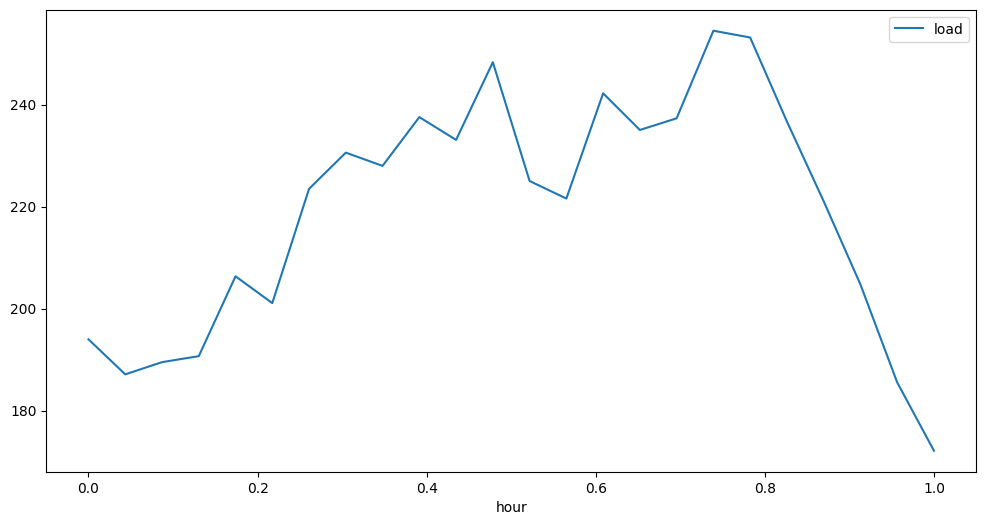

In [76]:
df.plot(figsize=(12,6))

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
len(df)

In [80]:
train = df.iloc[:20]
test = df.iloc[20:]

In [81]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



In [ ]:
df.head(),df.tail()

In [83]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:24]

In [86]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [85]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [ ]:
print(len(scaled_train),len(generator))

In [ ]:
inp,res = generator[0]
print(f'Given the Array: \n{inp.flatten()}')
print(f'Predict this res: \n {res}')


In [ ]:
inp.shape


In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [91]:
model = Sequential()
model.add(LSTM(20,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit(generator,epochs=50)

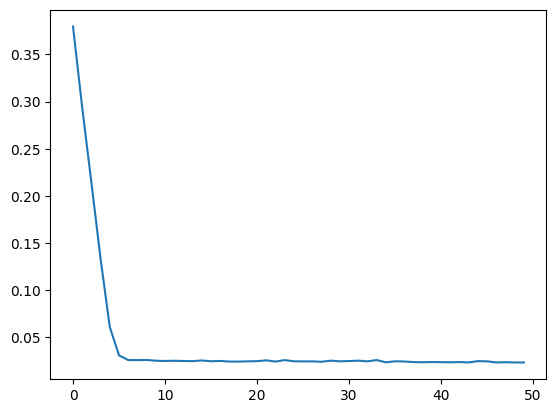

In [95]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [96]:
last_vals = scaled_train[:3]

In [97]:
last_vals = last_vals.reshape((1, n_input, n_features))

In [98]:
model.predict(last_vals)


1/1 [==============================] - 0s 166ms/step


array([[0.28928438]], dtype=float32)

In [99]:
scaled_test[0]


array([0.50379165])

In [100]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 37ms/step


In [101]:
test_predictions


[array([0.9268819], dtype=float32),
 array([0.9036636], dtype=float32),
 array([0.87560725], dtype=float32),
 array([0.9193125], dtype=float32)]

In [ ]:
test.head()

In [103]:
true_predictions = scaler.inverse_transform(test_predictions)

In [104]:
test['Predictions'] = true_predictions


<ipython-input-104-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='hour'>

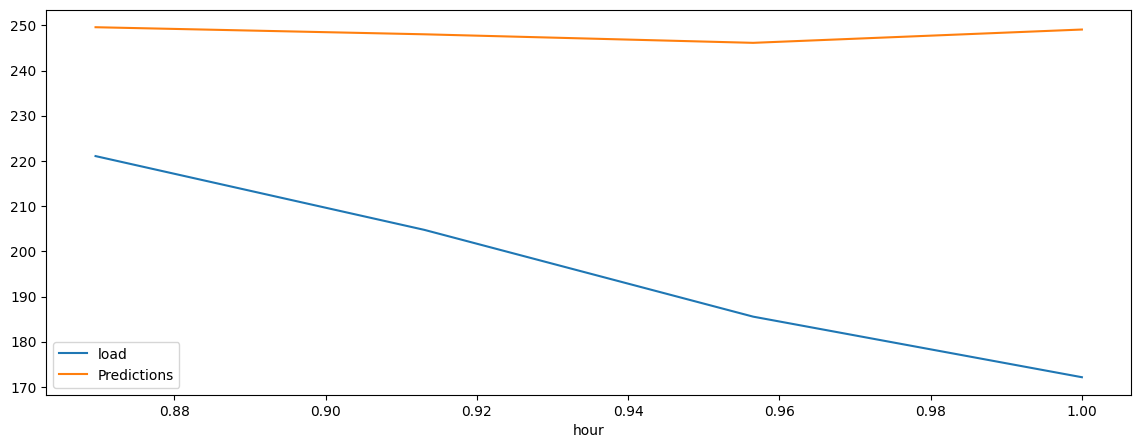

In [105]:
test.plot(figsize=(14,5))

In [107]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['load'],test['Predictions']))
print(rmse)


55.38716952771634
